# Ford GoBike System Data Exploration
## by Hammam Al-Alfi

## Preliminary Wrangling
This document explores individual rides made in a bike-sharing system covering the greater San Francisco Bay area on 2018.

### Load the data:

In [1]:
# import all the needed packages 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import os
import geopandas
import geoplot
from geopy import distance
import geopy
import shapely
import contextily as ctx
%matplotlib inline


In [2]:
#load the datasets of each month of 2018 and combine them into one master dataframe 
files_list = os.listdir('./fordgobike_data') # getting the data files names which are in a folder named fordgobike_data
df_list = []
# looping over the data files and having each file as a dataframe in a list called df_list
for file in files_list :
    df_list.append(pd.read_csv('./fordgobike_data/'+file))
# combine all the dataframes in the list to a master dataframe
df = pd.concat(df_list,ignore_index=True)


In [3]:
# dataset overview to get to know the variables
df.info()
print(df.isna().sum())
df.head(1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 199.1+ MB
duration_sec                   0
start_time                     0
end_time                       0
start_station_id           11771
start_station_name         11771
start_station_latitude         0
start_station_lon

duration_sec                start_time                  end_time  \
0         75284  2018-01-31 22:52:35.2390  2018-02-01 19:47:19.8240   

   start_station_id    start_station_name  start_station_latitude  \
0             120.0  Mission Dolores Park                37.76142   

   start_station_longitude  end_station_id            end_station_name  \
0              -122.426435           285.0  Webster St at O'Farrell St   

   end_station_latitude  end_station_longitude  bike_id   user_type  \
0             37.783521            -122.431158     2765  Subscriber   

  bike_share_for_all_trip  
0                      No

### Clean the data:

In [4]:
# start_time and end_time from object type to datetime type.

df.start_time = (pd.to_datetime(df.start_time)) 
df.end_time = (pd.to_datetime(df.end_time))

# rename duration_sec column and convert its values to timedelta type.
df.duration_sec = pd.to_timedelta(df.duration_sec,'seconds')
df.rename(columns={'duration_sec':'duration'},inplace=True)

In [5]:
df.start_time.head()

0   2018-01-31 22:52:35.239
1   2018-01-31 16:13:34.351
2   2018-01-31 14:23:55.889
3   2018-01-31 14:53:23.562
4   2018-01-31 19:52:24.667
Name: start_time, dtype: datetime64[ns]

In [6]:
df.end_time.head()

0   2018-02-01 19:47:19.824
1   2018-02-01 15:57:17.310
2   2018-02-01 10:16:52.116
3   2018-02-01 07:51:20.500
4   2018-02-01 06:58:31.053
Name: end_time, dtype: datetime64[ns]

In [7]:
df.duration.head()

0   20:54:44
1   23:43:42
2   19:52:56
3   16:57:56
4   11:06:06
Name: duration, dtype: timedelta64[ns]

Because i going to make use of the start_station coordinates and the end_station coordinates in my analysis , i going to use geographic packages and thier dependancies in this project and those include (geopandas,geoplot,geopy,contextily,shapely).
For this sake i need to do some geographical cleaning on my dataset. 

In [8]:
# getting geoseries of the start_station coordinates and the end_station coordinates
geoseries_start = geopandas.GeoSeries(geopandas.points_from_xy(df.start_station_longitude,df.start_station_latitude))
geoseries_end = geopandas.GeoSeries(geopandas.points_from_xy(df.end_station_longitude,df.end_station_latitude))
#setting the coordinate reference system 'crs' for both geoseries as WGS 84 system.
geoseries_start.crs = {'init' :'epsg:4326'} 
geoseries_end.crs = {'init' :'epsg:4326'} 

In [9]:
#having the start and end coordinates as columns in the dataframe
df['start_station_coor']=geoseries_start
df['end_station_coor'] = geoseries_end

In [10]:
geoseries_start.head()

0    POINT (-122.42644 37.76142)
1    POINT (-122.39420 37.79539)
2    POINT (-121.89480 37.34876)
3    POINT (-122.42124 37.77379)
4    POINT (-122.42624 37.77643)
dtype: geometry

In [11]:
geoseries_end.head()

0    POINT (-122.43116 37.78352)
1    POINT (-122.39420 37.79539)
2    POINT (-121.87712 37.32600)
3    POINT (-122.39975 37.78095)
4    POINT (-122.40345 37.78898)
dtype: geometry

In [88]:
#get the distances between the end and the start station in miles
# each distance represents the shortest distance on the surface of an ellipsoidal model of the earth between the two points.
if 'distance.csv' not in os.listdir():
    distances=[]
    for start,end in zip( geoseries_start,geoseries_end ):
        distances.append( distance.distance( (start.y,start.x) , (end.y,end.x) ).miles )
    df['distance'] = pd.Series(distances)
    pd.Series(distances).to_csv('distance.csv',index=False)
# because getting the distances takes long time i am going to have the distances as an csv file to load it again.
else: 
    df['distance']=pd.read_csv('./distance.csv')


I've downloaded a geojson file of the neighborhoods boundaries of San Francisco city to use in my analysis.
[The source of the data](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63)

In [13]:
#loading the geojson file of San Francisco city into geopandas dataframe
san_francisco = geopandas.read_file('./Planning Neighborhood Groups Map.geojson')

In [14]:
# getting the boundaries of San Francisco city as a shapely polygon 
# i am going to use these boundaries to distinguish the rides that took a place outside San Francisco from the ride that 
# took a place inside San Francisco 
sf_boundaries = shapely.geometry.box(san_francisco.total_bounds[0],san_francisco.total_bounds[1],san_francisco.total_bounds[2],san_francisco.total_bounds[3])

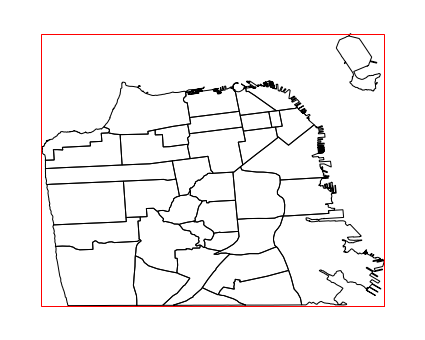

In [15]:
# the figure shows San Francisco map and the boundaries as a red box
ax=geoplot.polyplot(san_francisco)
geoplot.polyplot(geopandas.GeoSeries(sf_boundaries),edgecolor='red',ax=ax);

In [16]:
# getting start_sf which is a boolean panda series of true values for rides with start station inside the boundaries of San Francisco
# and false values for rides with start station outside the boundaries of San Francisco
# and the same goes for end_sf
start_sf=geoseries_start.apply(lambda x:x.within(sf_boundaries))
end_sf=geoseries_end.apply(lambda x:x.within(sf_boundaries))

In [17]:
# having start_sf and end_sf from the previous cell as columns in the main dataframe
df['sf_start']=start_sf
df['sf_end'] = end_sf

In [18]:
#73% of the rides started and ended inside San Francisco
(start_sf & end_sf).mean()

0.7311035289080287

In [19]:
#26% of the rides started and ended outside San Francisco
(~(start_sf & end_sf)).mean()

0.2688964710919714

In [20]:
# 96 rides started inside San Francisco and ended outside San Francisco or the vice-versa.
(start_sf ^ end_sf).sum()

96

In [21]:
df.head()

duration              start_time                end_time  start_station_id  \
0 20:54:44 2018-01-31 22:52:35.239 2018-02-01 19:47:19.824             120.0   
1 23:43:42 2018-01-31 16:13:34.351 2018-02-01 15:57:17.310              15.0   
2 19:52:56 2018-01-31 14:23:55.889 2018-02-01 10:16:52.116             304.0   
3 16:57:56 2018-01-31 14:53:23.562 2018-02-01 07:51:20.500              75.0   
4 11:06:06 2018-01-31 19:52:24.667 2018-02-01 06:58:31.053              74.0   

                                  start_station_name  start_station_latitude  \
0                               Mission Dolores Park               37.761420   
1  San Francisco Ferry Building (Harry Bridges Pl...               37.795392   
2                               Jackson St at 5th St               37.348759   
3                           Market St at Franklin St               37.773793   
4                              Laguna St at Hayes St               37.776435   

   start_station_longitude  end_station_id  \
0              -122.426435           285.0   
1              -122.394203            15.0   
2              -121.894798           296.0   
3              -122.421239            47.0   
4              -122.426244            19.0   

                                    end_station_name  end_station_latitude  \
0                         Webster St at O'Farrell St             37.783521   
1  San Francisco Ferry Building (Harry Bridges Pl...             37.795392   
2                              5th St at Virginia St             37.325998   
3                              4th St at Harrison St             37.780955   
4                               Post St at Kearny St             37.788975   

   end_station_longitude  bike_id   user_type bike_share_for_all_trip  \
0            -122.431158     2765  Subscriber                      No   
1            -122.394203     2815    Customer                      No   
2            -121.877120     3039    Customer                      No   
3            -122.399749      321    Customer                      No   
4            -122.403452      617  Subscriber                      No   

            start_station_coor             end_station_coor  distance  \
0  POINT (-122.42644 37.76142)  POINT (-122.43116 37.78352)  1.545972   
1  POINT (-122.39420 37.79539)  POINT (-122.39420 37.79539)  0.000000   
2  POINT (-121.89480 37.34876)  POINT (-121.87712 37.32600)  1.846937   
3  POINT (-122.42124 37.77379)  POINT (-122.39975 37.78095)  1.275856   
4  POINT (-122.42624 37.77643)  POINT (-122.40345 37.78898)  1.518033   

   sf_start  sf_end  
0      True    True  
1      True    True  
2     False   False  
3      True    True  
4      True    True

In [22]:
df.describe()

duration  start_station_id  start_station_latitude  \
count                 1863721      1.851950e+06            1.863721e+06   
mean   0 days 00:14:17.302571      1.196744e+02            3.776678e+01   
std    0 days 00:39:30.378862      1.003976e+02            1.057689e-01   
min           0 days 00:01:01      3.000000e+00            3.726331e+01   
25%           0 days 00:05:50      3.300000e+01            3.777106e+01   
50%           0 days 00:09:16      8.900000e+01            3.778107e+01   
75%           0 days 00:14:32      1.860000e+02            3.779625e+01   
max           0 days 23:59:26      3.810000e+02            4.551000e+01   

       start_station_longitude  end_station_id  end_station_latitude  \
count             1.863721e+06    1.851950e+06          1.863721e+06   
mean             -1.223492e+02    1.181730e+02          3.776690e+01   
std               1.654634e-01    1.004403e+02          1.056483e-01   
min              -1.224737e+02    3.000000e+00          3.726331e+01   
25%              -1.224114e+02    3.000000e+01          3.777106e+01   
50%              -1.223974e+02    8.800000e+01          3.778127e+01   
75%              -1.222865e+02    1.830000e+02          3.779728e+01   
max              -7.357000e+01    3.810000e+02          4.551000e+01   

       end_station_longitude       bike_id      distance  
count           1.863721e+06  1.863721e+06  1.863721e+06  
mean           -1.223487e+02  2.296851e+03  9.884353e-01  
std             1.650597e-01  1.287733e+03  6.386847e-01  
min            -1.224737e+02  1.100000e+01  0.000000e+00  
25%            -1.224094e+02  1.225000e+03  5.399725e-01  
50%            -1.223971e+02  2.338000e+03  8.534669e-01  
75%            -1.222894e+02  3.333000e+03  1.296004e+00  
max            -7.357000e+01  6.234000e+03  4.058059e+01

### What is the structure of your dataset?
The dataset contains information regarding 1863721 bike-rides as follows:

duration -- duration of the trip (timedelta)<br>
start_time -- Start Time and Date of the trip (datetime)<br>
end_time -- End Time and Date (datetime)<br>
start_station_id -- Start Station ID (int) with missing values<br>
start_station_name -- Start Station Name (str) with missing values<br>
start_station_latitude -- Start Station Latitude (int)<br>
start_station_longitude -- Start Station Longitude (int)<br>
end_station_id -- End Station ID (int) with missing values<br>
end_station_name -- End Station Name (str) with missing values<br>
end_station_latitude -- End Station Latitude (int)<br>
end_station_latitude -- End Station Latitude (int)<br>
bike_id -- Bike ID (int)<br>
user_type -- User Type (Subscriber or Custome) (str)<br>
bike_share_for_all_trip -- if member is enrolled in the Bike Share for All program for low-income residents then 'Yes',else 'No' (str)<br>

I've added another variable of the shortest distance on the surface of an ellipsoidal model of the earth between the start and end station.
### What is/are the main feature(s) of interest in your dataset?
There are many intrested stuff regarding this dataset, but i wanna study what affects duration of the trip.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
I think the distance,location,user type and if member is enrolled in the Bike Share for All program may support my feature of interest.



## Univariate Exploration



I am going to start with studing the distribution of the duration by plotting a histogram.

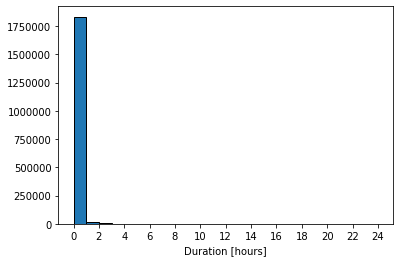

In [23]:
# plot the distribution of the duration of the trips  
#by dividing the duration by a timedelta with a specific unit we  get a float of the duration of that unit 
#here i chose to divide the duration by 1 hour and setting bins from 1 to 24 hours
plt.hist(df.duration/np.timedelta64(1,'h'),bins=np.arange(0,24+1,1),edgecolor='black')
plt.xticks(np.arange(0,24+1,2),labels=np.arange(0,24+1,2))
plt.xlabel('Duration [hours]');


From the histogram above we can tell that there are outliers in duration values and the most trips are of duration less than an  hour.
So i am going to adjust the bins,set the limits and do a transformation to understand the distribution of the duration. 

Text(0.5, 0, 'Duration [minutes]')

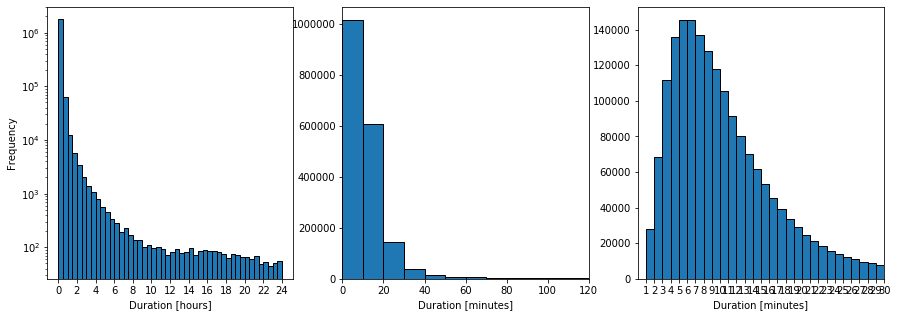

In [24]:
#plotting a 3 subplots on the same row .
fig,ax=plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
# setting current axes to 0 then plot a histogram of duration as hour with bin range from 0 to 24 hours with bin size of 0.5 hour
# and using log scale for the y axis.
plt.hist(df.duration/np.timedelta64(1,'h'),bins=np.arange(0,24+0.5,0.5),edgecolor='black',log=True)
plt.xticks(np.arange(0,24+1,2),labels=np.arange(0,24+1,2))
plt.xlabel('Duration [hours]')
plt.ylabel('Frequency')

plt.sca(ax[1])

# setting current axes to 1 then plot a histogram of duration as minutes with bin range from 0 to 2 hours(120 minutes) with bin size of 10 minutes
# and using log scale for the y axis.
plt.hist(df.duration/np.timedelta64(1,'m'),bins=np.arange(0,120+10,10),edgecolor='black')
plt.xlabel('Duration [minutes]')
plt.xlim(0,120)
plt.sca(ax[2])

# setting current axes to 2 then plot a histogram of duration as minutes with bin range from 0 to 0.5 hours(30 minutes) with bin size of 1 minute
# and using log scale for the y axis.

plt.hist(df.duration/np.timedelta64(1,'m'),bins=np.arange(0,30+1,1),edgecolor='black')
plt.xticks(np.arange(1,30+1),np.arange(1,30+1))
plt.xlim(0,30)
plt.xlabel('Duration [minutes]')


For the three histograms above from left to right , for the first one i chose to use log scale for the y axis with bin size of half an hour to see all the observation.<br>

In second one i  reduced the bin size to ten minutes and limited the duration axis to 2 hours,from this plot you can see that there still outliers and most of the trips are of duration less than 30 minutes.<br>

In the third one i reduced the the duration axis to the  third quantial which is 15 minutes and chose a bin size of 30 seconds.
Duration variable is somehow right-skewed.

Another approache is to plot the log distribution of the data as a histogram.

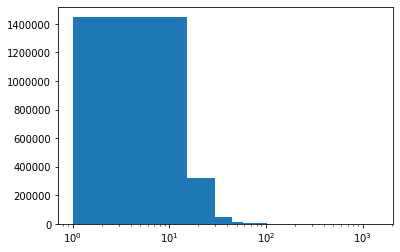

In [25]:
#plotting a histogram of duration as minutes with 100 bins and setting a log  scale for the x axis.
plt.hist((df.duration/np.timedelta64(1,'m')),bins=100)
plt.xscale('log');



We need to get a log bins to get the proper log histogram.

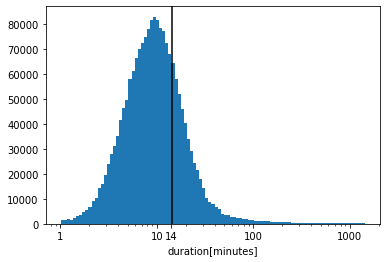

In [26]:
duration_log=np.log10(df.duration/np.timedelta64(1,'m')) # getting log base 10 of the duration as minutes to use to for getting a log bins.
plt.hist((df.duration/np.timedelta64(1,'m')),bins=10**np.linspace(duration_log.min(),duration_log.max(),100)) #plotting a histogram of the duration as minutes with 100 bins that are log scaled
plt.xscale('log')
plt.xlabel('duration[minutes]')
plt.xticks([1,10,14,100,1000],[1,10,14,100,1000]) 
plt.axvline((df.duration/np.timedelta64(1,'m')).mean(),color='black');# plotting a vertical line of the mean of  the duration


Here we got a log distribution of the data and it's normally distributed and the plot also has the mean of the duration as a vertical line .

Now i am going to the distance variabel to study its distribution.

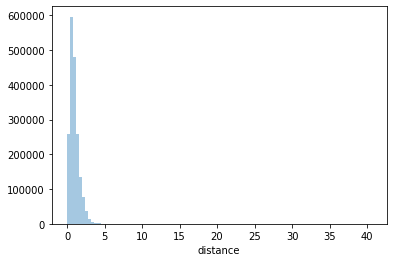

In [27]:
#  a histogram of the distance with 100 bins.
sns.distplot(df.distance,kde=False,bins=100);

The histogram above shows that there's a spike on the left so i am going to do a square root transformation and getting the log scale of the y axis to show the outliers then plot the distance data.

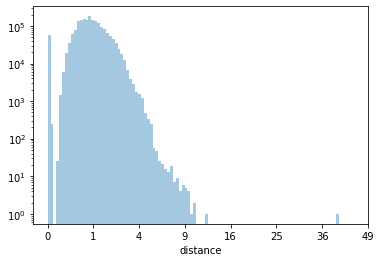

In [28]:
distance_sqrt=np.sqrt(df.distance)# getting the square root of the distance to use it for plotting a square root scale 
sns.distplot(distance_sqrt,kde=False,bins=100)
plt.xticks(np.arange(0,7+1),np.arange(0,7+1)**2) # relabeling the xticks where the real values of the distance are the square root values squared.
plt.yscale('log') 

Here we see that there's a gap in the values and there's trips with ditance over 36 miles.

So i am going to zoom on this gap to figure out what's going on.

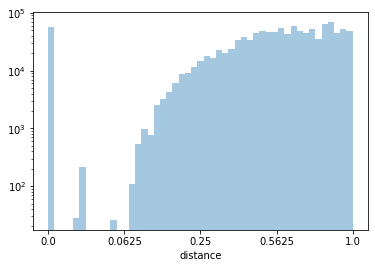

In [29]:
# the same plot as the one on the previous cell but zooming in by reducing the range of the bins and changing xticks.
distance_sqrt=np.sqrt(df.distance)
sns.distplot(distance_sqrt,kde=False,bins=np.linspace(0,1,50))
plt.xticks(np.arange(0,1+0.25,0.25),np.arange(0,1+0.25,0.25)**2)
plt.yscale('log')

In [30]:
(df.distance==0).sum()

56158

So by zooming in to the distances between zero and one mile we see that there is a spike around the zero and by getting the count of the zero distances we see that there's 56158 trips with zero distance 
and this means that the rider took the bike from certain station and bring it back to the same station.<br>
In addition to that we see that there are some stations with close proximity less than 0.0625 miles.

By excluding the outliers and the zero values of the distance (where the biker return the bike the same station) we get this plot shown down below.

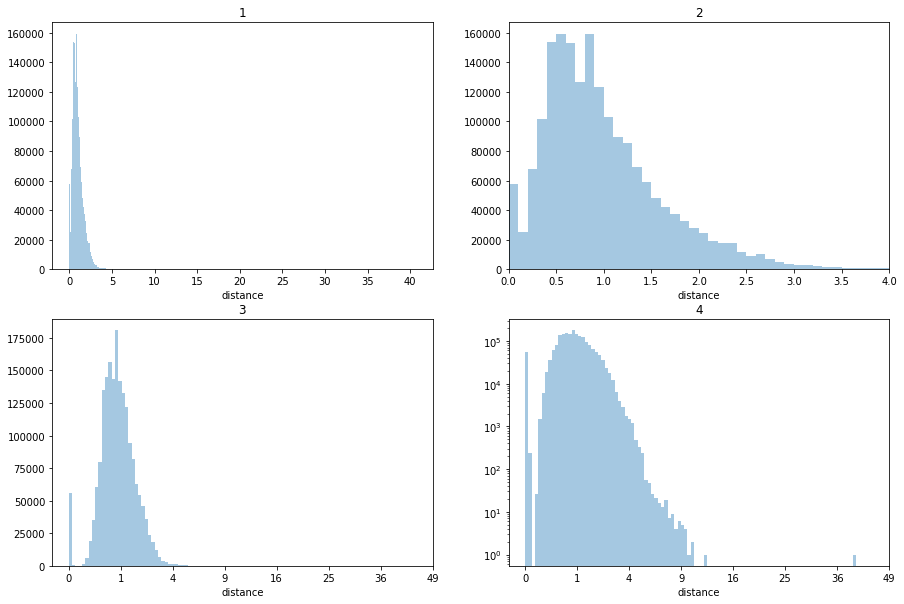

In [31]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
# plotting histogram on the first axes of  the distance with bin range from zero to the maximum value of the distance and with bin size of 0.1 mile
sns.distplot(df.distance,bins=np.arange(0,df.distance.max()+0.1,0.1),kde=False,ax=ax[0,0])
ax[0,0].set_title('1')

# plotting histogram on the second axes of  the distance with bin range from zero to the maximum value of the distance and with bin size of 0.1 mile
# but limiting the x axis from 0 to 4 miles
sns.distplot(df.distance,bins=np.arange(0,df.distance.max()+0.1,0.1),kde=False,ax=ax[0,1])
ax[0,1].set_xlim(0,4)
ax[0,1].set_title('2')
# plotting histogram on the third axes of  the square root values of the distance with 100 bins and setting the xticks and their labels  to show the real values of the distance
distance_sqrt = np.sqrt(df.distance)
sns.distplot(distance_sqrt,kde=False,bins=100,ax=ax[1,0])
ax[1,0].set_title('3')
ax[1,0].set_xticks(np.arange(0,7+1,1))
ax[1,0].set_xticklabels(np.arange(0,7+1,1)**2)
# plotting histogram on the forth axes of the square root values of the distance the distance and log scale for the y axis.
sns.distplot(distance_sqrt,kde=False,bins=100,ax=ax[1,1]);
ax[1,1].set_xticks(np.arange(0,7+1,1))
ax[1,1].set_xticklabels(np.arange(0,7+1,1)**2)
ax[1,1].set_yscale('log')
ax[1,1].set_title('4');


The histogram above summarises the distribution plots of the distance .
plot num.1 shows that the majority of the distances falls bellow 5 miles.
plot num.2 shows how there's a spike between 0 and 0.1 and then how the distribution goes right skewed.
plot num.3 and num.4 shows the distrbution when having a square root transformation to the distances and getting a log scale of the y axis .

Now i am going to plot a bar plots that show the top five start stations and end stations with the most trips count.

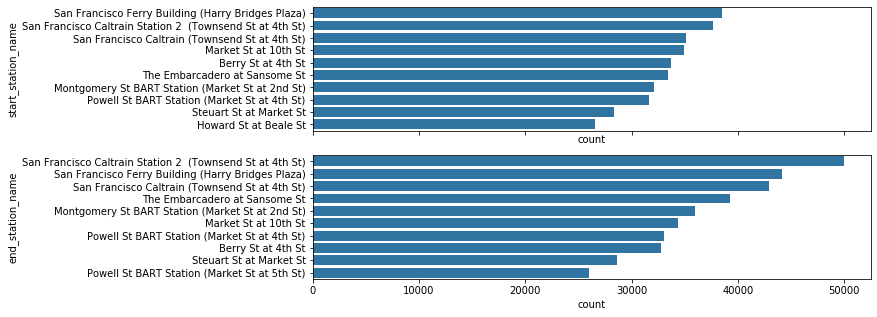

In [32]:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)
plt.sca(ax[0])
# the first axes
#plotting count plot showing the frequency of the top ten start station 
# order arguments used to get the top 10 start station names and showing them from most frequent to the less frequent.
sns.countplot(y=df.start_station_name,order = df.start_station_name.value_counts().head(10).index,color = sns.color_palette()[0])
# the second axes
# the same as the first one but for end stations.
plt.sca(ax[1])
sns.countplot(y=df.end_station_name,order = df.end_station_name.value_counts().head(10).index,color = sns.color_palette()[0]);


The two plots above shows the top ten start stations and end stations  with the most trips count.


Now i am going to investigate the unique bikes using bike_id column, starting first with plotting the distribution unique bikes trips count.

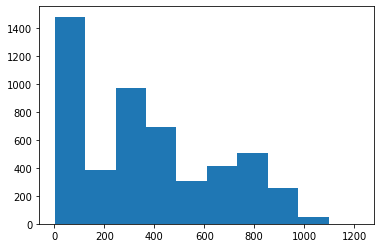

In [33]:
# a histogram of the value counts of each unique bike .
plt.hist(df.bike_id.value_counts());

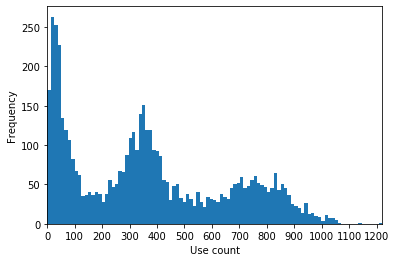

In [34]:
# a histogram of the value counts of each unique bike with 100 equally  sized  bins with a range from the minimum of the unique bikes trips count to the maximum

plt.hist(df.bike_id.value_counts(),bins=np.linspace(df.bike_id.value_counts().min(),df.bike_id.value_counts().max(),100))
plt.xlabel('Use count')
plt.ylabel('Frequency')
plt.xlim(df.bike_id.value_counts().min(),df.bike_id.value_counts().max())
plt.xticks(np.arange(0,1200+100,100),np.arange(0,1200+100,100));

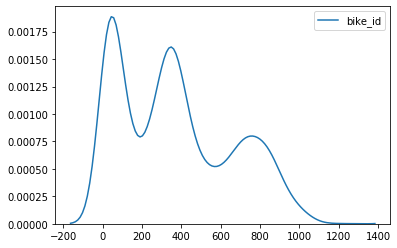

In [35]:
# a density curve of the unique bike trips value counts.
sns.kdeplot(df.bike_id.value_counts());

The histogram and the density curve shows the distribution of the count of the trips each unique bike has done.
It tells that the distribution of the bikes trips count started with large amount of bikes that are not heavely used (bikes  that are used less than 100 times) then the distribution gose down and up twice and finally goes down to the bikes that used more than 800 times.

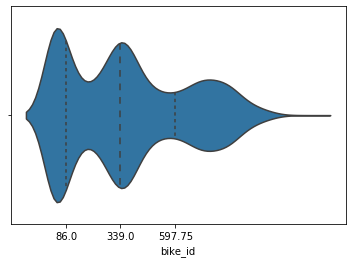

In [36]:
# a violin plot of the distibution of the unique bike trips value counts and resetting the xticks to show the quantiles of the data.
tikcs=[df.bike_id.value_counts().quantile(0.25),df.bike_id.value_counts().quantile(0.5),df.bike_id.value_counts().quantile(0.75)]
sns.violinplot(df.bike_id.value_counts(),inner ='quartile');
plt.xticks(tikcs,tikcs);

The violin plot shows the first,second and the third quantiles and the distribution of the unique bikes trips count.

The next variable i am going to investigate is the time and the date of the trip .

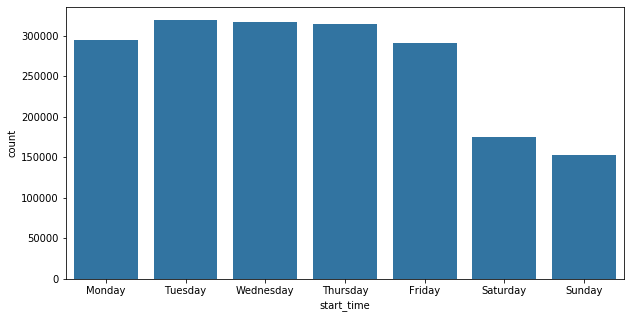

In [37]:
# plotting a count plot of start day of the trip and using order argument to show the days in order of the starting day of the week to the weekend.
ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize = (10,5))
sns.countplot(df.start_time.dt.day_name(),order=ordered_days,color=sns.color_palette()[0]);

The bar plot above shows the count of the trips for weekdays ,Saturday and Sunday are the days with the lowest trips count.


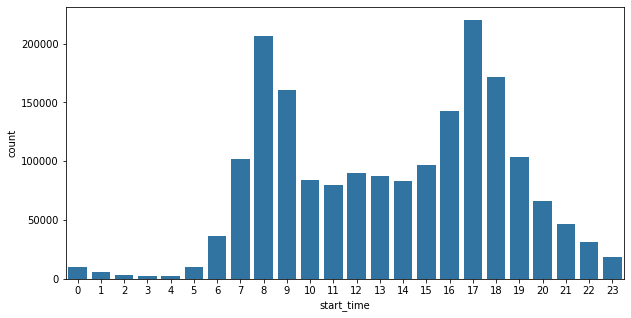

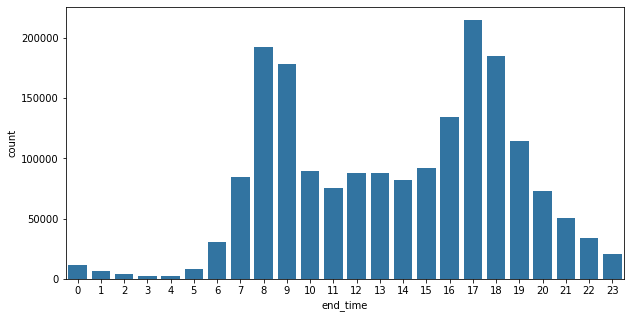

In [38]:
#two subplots one for the count of the start time of trips per day hours and the other one for the end time
plt.figure(figsize = (10,5))
sns.countplot(df.start_time.dt.hour,color=sns.color_palette()[0])
plt.figure(figsize = (10,5))
sns.countplot(df.end_time.dt.hour,color=sns.color_palette()[0]);

The bar plots above shows the trips count for each hour ,the peak hours are 8:00 and 17:00.

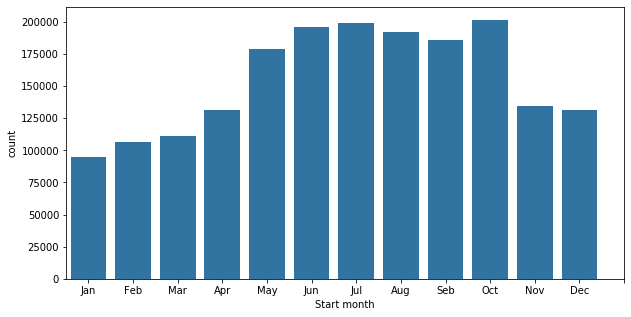

In [39]:
# count plot of trips per month and using xtikcs to show  the abbreviation of the month instade of its number.
ordered_months= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Seb','Oct','Nov','Dec']
plt.figure(figsize = (10,5))
sns.countplot(df.start_time.dt.month,color=sns.color_palette()[0]);
plt.xticks(ticks=np.arange(0,12+1,1),labels=ordered_months)
plt.xlabel('Start month');

The bars above shows the monthly trips count and it shows that October has the most amount trips and January has the lowest amount.

Now i am going to investigate the percentages of the user type and the percentage of Bike Share For all programe trips.

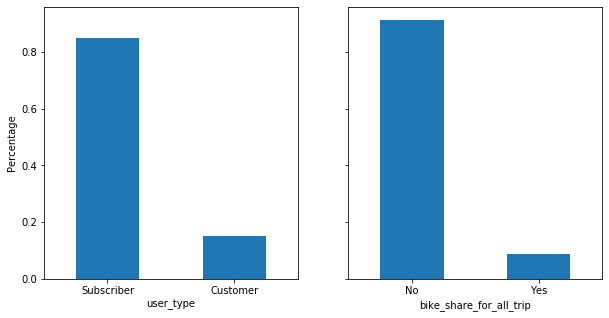

In [40]:
fig,ax=plt.subplots(1,2,figsize=(10,5),sharey='row') # plotting to subplots 1 row 2 columns that shares the y axis 
# the first subplot is a bar plot of the normaized value counts of each user type which shows the percentages.
df.user_type.value_counts(normalize=True).plot.bar(ax=ax[0])
# the first subplot is a bar plot of the normaized value counts of each value in bike_share_for_all_trip which shows the percentages.

df.bike_share_for_all_trip.value_counts(normalize=True).plot.bar(ax=ax[1])

ax[0].set_xlabel('user_type') #setting x axis label for axes 0
ax[0].tick_params(labelrotation=0) #rotate  ticks for axes 0
ax[1].set_xlabel('bike_share_for_all_trip')#setting x axis label for axes 1 
ax[1].tick_params(labelrotation=0) #rotate  ticks for axes 0
ax[0].set_ylabel('Percentage');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
The distribution of the duration is somehow logarithmically normally distributed,with mean value of 14 minutes and no values less than a minute and no values larger than a day.And i think the unusual points is having rides with pretty long durations as outliers.Yes  i needed to do a logarithmatic transformation.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
Yeah, trips with zero and quite low distances and the distribution of unique bikes trips count.Yes, i manipulate the trip datetime columns to get the proper time unit to use in my bins and in the count plots.And i did a square root transformation on the distance to plot its distribution.


## Bivariate Exploration


Starting the Bivariate Exploration by descovering the relation between the distance and the duration of the trip.

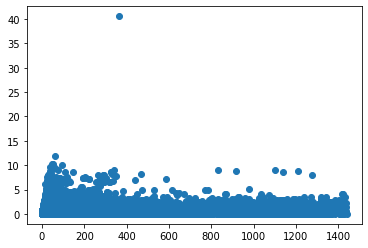

In [41]:
#plotting a scatter plot of the distane and duration as minutes.
plt.scatter(y=df.distance,x=(df.duration/np.timedelta64(1,'m')));

The scatter plot above tells nothing except showing the outlier when the distance is 40 miles and that the majority of the trips are of duration between 0-5 miles.

By doing a logarithmic transformation on the duration and square root transformation on the distance and replotting the previous scatter plot we see the gap mentioned before .

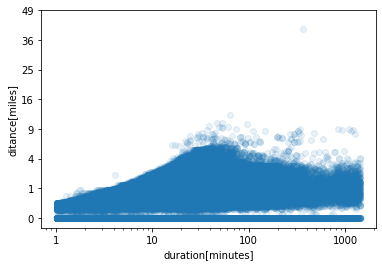

In [42]:
#plotting a scatter plot of the square root of distance and duration as minutes and reducing the transparency of the points to 0.1 

plt.scatter(y=np.sqrt(df.distance),x=(df.duration/np.timedelta64(1,'m')),alpha=0.1)
# log scale for the x axis
plt.xscale('log')
plt.yticks([0,1,2,3,4,5,6,7],[0,1,4,9,16,25,36,49]) #relabling the ticks of the y axis
plt.xlabel('duration[minutes]')
plt.ylabel('ditance[miles]')
plt.xticks([1,10,100,1000],[1,10,100,1000]);#relabling the ticks of the x axis



Down below i excluded the values when distance equals zero to get a cleaner figure. 

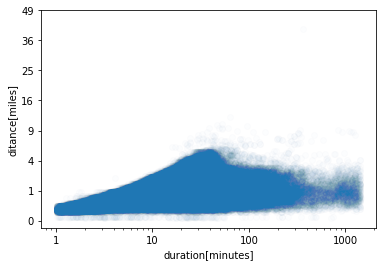

In [43]:
# the same plot as the one on the previous cell but excluding all the values when distance equals zero
plt.scatter(y=np.sqrt(df.distance[df.distance!=0]),x=(df.duration/np.timedelta64(1,'m'))[df.distance!=0],alpha=0.01)
plt.xscale('log')
plt.yticks([0,1,2,3,4,5,6,7],[0,1,4,9,16,25,36,49])
plt.xlabel('duration[minutes]')
plt.ylabel('ditance[miles]')
plt.xticks([1,10,100,1000],[1,10,100,1000]);



Instade of this i am going to get a heatmap to get to know the relation better.

In [44]:
df['duration_hours']=df.duration/np.timedelta64(1,'h') # getting a colum of duration as hours 
df['duration_minutes']=df.duration/np.timedelta64(1,'m') # getting a colum of duration as minutes 

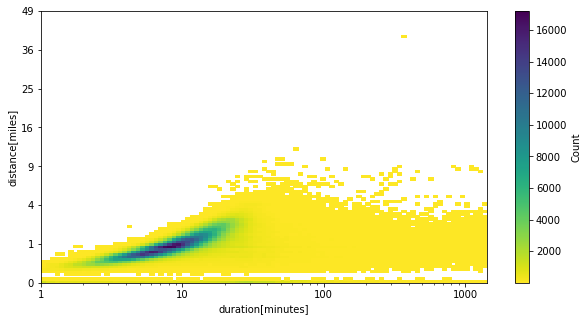

In [45]:
#getting the x axis bins for the heat map as 100 log scaled bins started from the minimum value to the maximum value of the duration
x_bins=10**np.linspace(np.log10(df.duration_minutes).min(),np.log10(df.duration_minutes).max(),100)

#getting the y axis bins for the heat map as 100 square root scaled bins started from the minimum value to the maximum value of the distance
y_bins = np.linspace(distance_sqrt.min(),distance_sqrt.max(),100)

plt.figure(figsize=(10,5))
#plotting the heat map using the duration as minutes and the square root of the distance and setting the bins .
plt.hist2d(x=df.duration_minutes,y=distance_sqrt, cmap = 'viridis_r',bins=[x_bins,y_bins],cmin=1)
# using log scale for the x axis,relabeling the ticks,setting labels for the axis and the color bar.
plt.xscale('log')
plt.yticks([0,1,2,3,4,5,6,7],[0,1,4,9,16,25,36,49])
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.colorbar().set_label('Count')
plt.xlabel('duration[minutes]')
plt.ylabel('distance[miles]');

The heat map above gives the conclusion of the two previous scatter plots , it shows the desnsity of  the data, the gap between the quite low distances including zero and the other distances ,the outliers  and it shows a positive relation between the log of the duration and the square root of the distance (The purple line).

Now i am going to plot a bar plots of the duration and the weekdays,month and day hours.

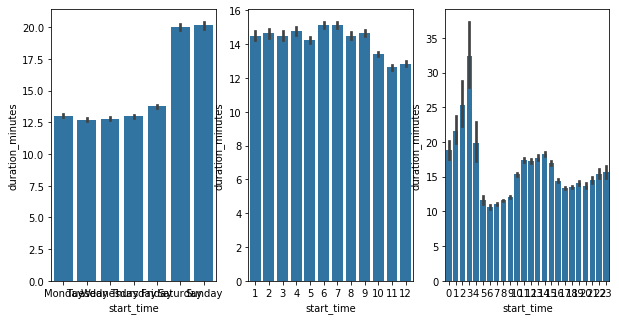

In [46]:
fig,ax=plt.subplots(1,3,figsize=(10,5))
# plotting three barplots of the mean of duration as minutes and start time as weekday
sns.barplot(x=df.start_time.dt.day_name(),y=df.duration_minutes,order=ordered_days,ax=ax[0],color=sns.color_palette()[0])
#start time as months
sns.barplot(x=df.start_time.dt.month,y=df.duration_minutes,color=sns.color_palette()[0],ax=ax[1])
#start time as day hours 
sns.barplot(x=df.start_time.dt.hour,y=df.duration_minutes,color=sns.color_palette()[0],ax=ax[2]);



Sounds interesting! The tips count are the lowest for Saturday and Sunday but the trips duration on average are the longest for these days 
The same gose trips took a place at 8:00 and 17:00 o'clock and we see that trips that took a place at 3:00 o'clock have on average the longest duration.
Monthly scale it seems trips on average slightly have the same duration.    

Now i am  going to get an adaptive  histogram showing the percentage of the user type with respect to the duration.  

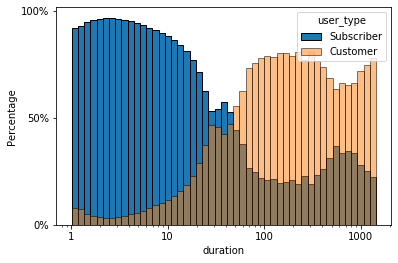

In [47]:
# getting a log scaled bins of the duration as minutes
bin_edges = 10**np.linspace(np.log10(df.duration_minutes).min(),np.log10(df.duration_minutes).max(),50)
# getting the number of points in each bin
bin_idxs = pd.cut(df.duration_minutes,bin_edges,include_lowest =True,right=True,labels=False).astype(int)
pts_per_bin = df.groupby(bin_idxs).size()
#plotting a weighted histogram of the duration as minutes and Subscriber user type
plt.hist(df.duration_minutes,
         bins = bin_edges,
         weights = (df.user_type=='Subscriber')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='Subscriber')
#plotting a weighted histogram of the duration as minutes and Customer user type
plt.hist(df.duration_minutes,
         bins = bin_edges,
         weights = (df.user_type=='Customer')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='Customer',
        alpha=0.5)
#polishing the plot by setting the title of the legend,relabeling the ticks and setting the labels.
plt.legend(title='user_type')
plt.xscale('log')
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.yticks([0,0.5,1],['0%','50%','100%'])
plt.xlabel('duration')
plt.ylabel('Percentage');

Form the plot above it seems that trips with shorter durations have heigher percentages of the biker to be a Subscriber.And from the plot we can tell Customers are more likely to do trips with longer durations than the Subscribers. 

I am  going to get another adaptive  histogram showing the percentage of the bike_share_for_all with respect to the duration.  

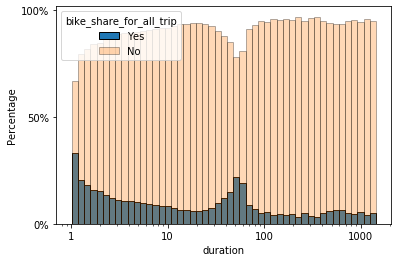

In [48]:
# getting a log scaled bins of the duration as minutes
bin_edges = 10**np.linspace(np.log10(df.duration_minutes).min(),np.log10(df.duration_minutes).max(),50)
# getting the number of points in each bin
bin_idxs = pd.cut(df.duration_minutes,bin_edges,include_lowest =True,right=True,labels=False).astype(int)
pts_per_bin = df.groupby(bin_idxs).size()

#plotting a weighted histogram of the duration as minutes and bike_share_for_all_trip is Yes
plt.hist(df.duration_minutes,
         bins = bin_edges,
         weights = (df.bike_share_for_all_trip=='Yes')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='Yes')

#plotting a weighted histogram of the duration as minutes and bike_share_for_all_trip is No

plt.hist(df.duration_minutes,
         bins = bin_edges,
         weights = (df.bike_share_for_all_trip=='No')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='No',
        alpha=0.3)

#polishing the plot by setting the title of the legend,relabeling the ticks and setting the labels.
plt.legend(title='bike_share_for_all_trip')
plt.xscale('log')
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.yticks([0,0.5,1],['0%','50%','100%'])
plt.xlabel('duration')
plt.ylabel('Percentage');

From the plot above members that are not enrolled in Bike Share For All Trip always have heigher percentages than the ones  that are not enrolled no matter the duration of the trip was.

Now i am going to investigate the relation between the distance and bike_share_for all by plotting an adaptive  histogram.

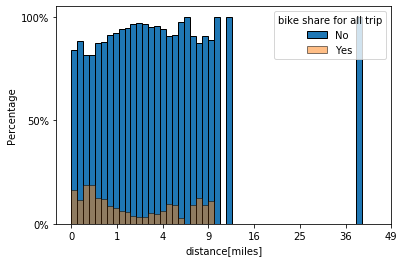

In [49]:
# getting bins of the square root of the distance

bin_edges = np.linspace(np.sqrt(df.distance).min(),np.sqrt(df.distance).max(),50)
#getting the number of points in each bin
bin_idxs = pd.cut(np.sqrt(df.distance),bin_edges,include_lowest =True,right=True,labels=False).astype(int)
pts_per_bin = df.groupby(bin_idxs).size()

#plotting a weighted histogram of the square root of the distance and bike_share_for_all_trip is No
plt.hist(np.sqrt(df.distance),
         bins = bin_edges,
         weights = (df.bike_share_for_all_trip=='No')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='No')
#plotting a weighted histogram of the square root of the distance and bike_share_for_all_trip is Yes

plt.hist(np.sqrt(df.distance),
         bins = bin_edges,
         weights = (df.bike_share_for_all_trip=='Yes')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='Yes',
        alpha=0.5)
#polishing the plot by setting the title of the legend,relabeling the ticks and setting the labels.

plt.xticks([0,1,2,3,4,5,6,7],[0,1,4,9,16,25,36,49]);
plt.legend(title='bike share for all trip')
plt.xlabel('distance[miles]')
plt.yticks([0,0.5,1],['0%','50%','100%'])
plt.ylabel('Percentage');



From the plot above members that are not enrolled in Bike Share For All Trip always have heigher percentages than the ones  that are not enrolled no matter the distance between the stations  was.And we can tell that there are some quite heigher distances(outliers) that are all done by members that are not enrolled in this program

Now i am going to get the last adaptive plot showing the relation between the distance and the user type. 

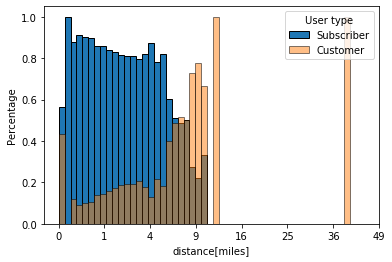

In [50]:
# getting bins of the square root of the distance

bin_edges = np.linspace(np.sqrt(df.distance).min(),np.sqrt(df.distance).max(),50)
# getting the number of points in each bin

bin_idxs = pd.cut(np.sqrt(df.distance),bin_edges,include_lowest =True,right=True,labels=False).astype(int)
pts_per_bin = df.groupby(bin_idxs).size()

#plotting a weighted histogram of the square root of the distance and Subscriber user type

plt.hist(np.sqrt(df.distance),
         bins = bin_edges,
         weights = (df.user_type=='Subscriber')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         label='Subscriber')

#plotting a weighted histogram of the square root of the distance and Customer user type

plt.hist(np.sqrt(df.distance), bins = bin_edges,
         weights = (df.user_type=='Customer')/pts_per_bin[bin_idxs].values,
         edgecolor='black',
         alpha=0.5,
         label='Customer')

#polishing the plot by setting the title of the legend,relabeling the ticks and setting the labels.

plt.xticks([0,1,2,3,4,5,6,7],[0,1,4,9,16,25,36,49]);
plt.legend(title='User type')
plt.xlabel('distance[miles]')
plt.ylabel('Percentage');

From this plot it's obvious that the heigher the distance between the stations the heigher the percentage of the trip to be done by a customer.
And trips with shorter distances between the stations are more likely to be done by a Subscriber.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
- For short durations there are a dense group of trips that follow a positive relation between the log of thier duration and the square root of thier distance .
- For quite short distances and for zero distances the durations of the trips are of wide range from one to more than 1000 minutes .
- With respect to date and time we see that Saturday and Sunday trips on average are of longer durations than the other days,trips that started from 00:00 to 04:00 are on average of longer durations that the ones started on the other hours of the day
- Trips that done by Customers are more likely to have longer duration than the ones done by Subsecribers and the vice-versa.
- Trips that done by Customers are more likely to have longer distance than the ones done by Subsecribers and the vice-versa.



## Multivariate Exploration


First i am going to start with having a heat map showing the relation between the mean duration in minutes and bike_share_for_all_trip and the user_type.

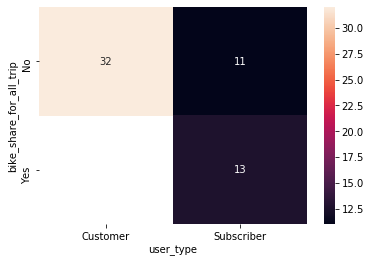

In [51]:
#getting the grouped means with respect to both bike_share_for_all_trip and user_type and then resetting the index
group_mean = df.groupby(['bike_share_for_all_trip', 'user_type']).duration_minutes.mean()
group_mean = group_mean.reset_index()
#reshape the group_mean to use it in heatmap plot
group_mean = group_mean.pivot(index = 'bike_share_for_all_trip', columns = 'user_type',
                            values = 'duration_minutes')
#plotting a heat map and use annotations.
sns.heatmap(group_mean, annot = True);



We see here that there's no one Customer enrolled in Bike Share For All program.<br> Subscribers that are enrolled in  Bike Share For All program do trips with durations 2 miles on average longer than the ones that are not enrolled in the Program. <br>
For the bikers that are not enrolled in Bike Share For All program the Customers do on average trips longer than the Subscribers.

Now i am going to study the duartion, user_type and the datetime of the trip

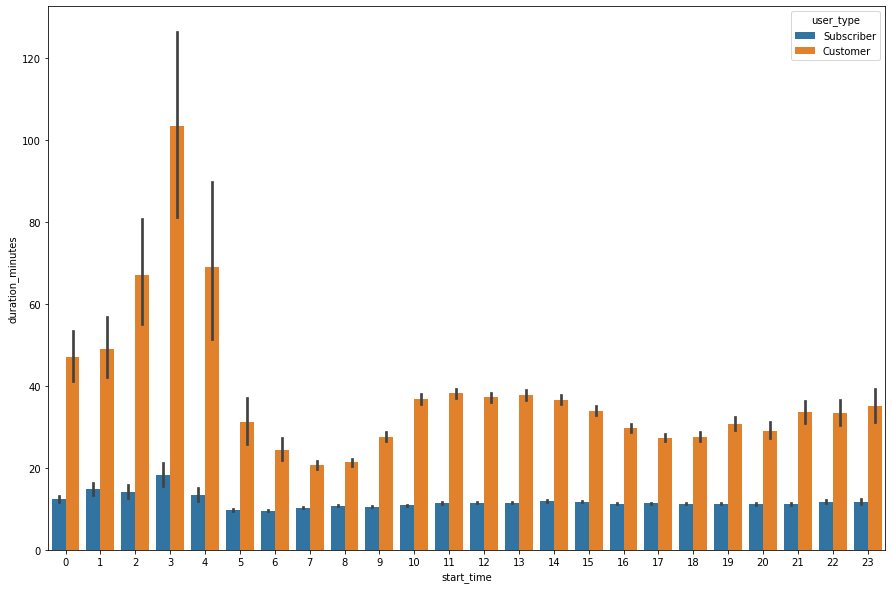

In [52]:
#barplot of the duration and the day hours with user_type as a hue
plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.hour,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.user_type,palette=['C0','C1'])


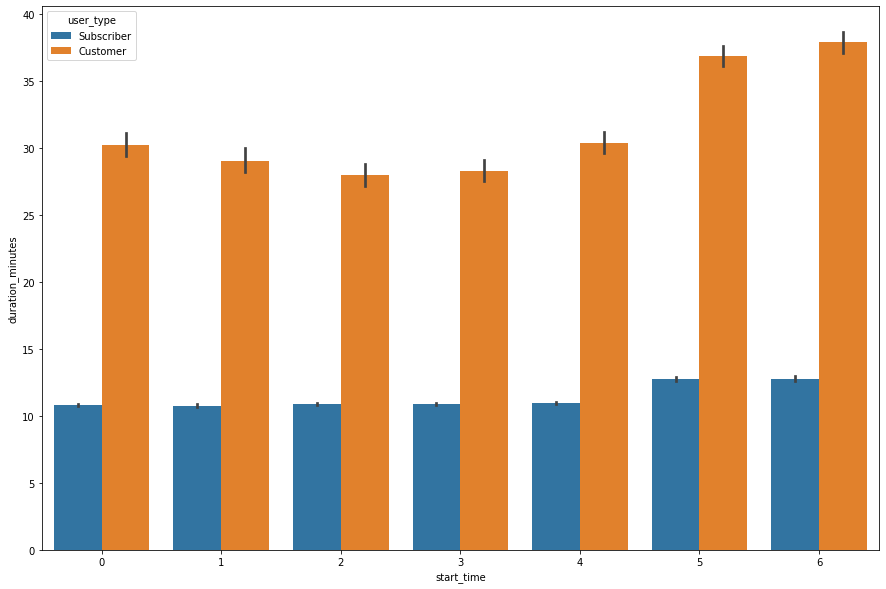

In [53]:
#barplot of the duration and the day weekdays with user_type as a hue
plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.dayofweek,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.user_type,palette=['C0','C1'])


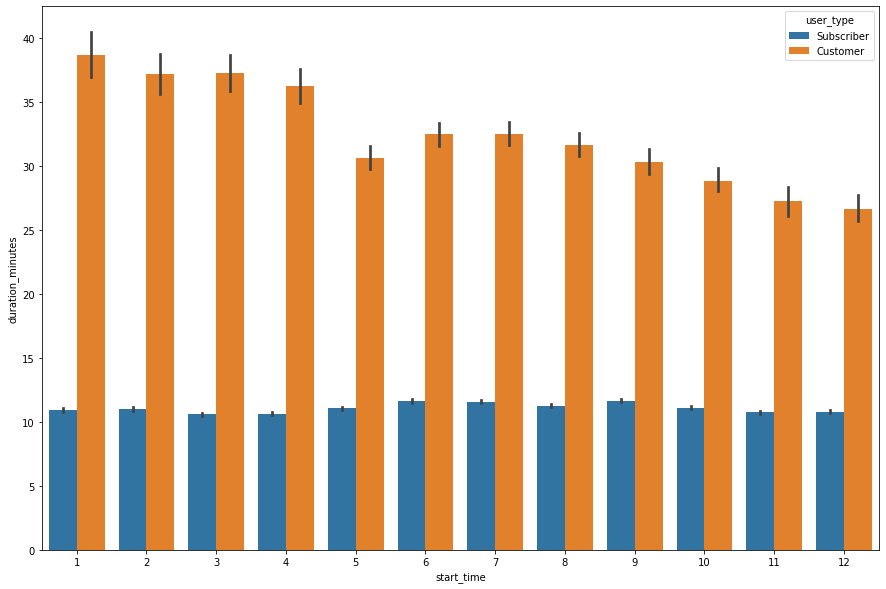

In [54]:
#barplot of the duration and the months with user_type as a hue

plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.month,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.user_type,palette=['C0','C1'])


From the barplots above we can tell that no matter the start time,month or week day of the trip the Subscirbers are on average do trips with durations longer than the Customers.

Now i am going to study the duartion, bike_share_for_all_trip and the datetime of the trip

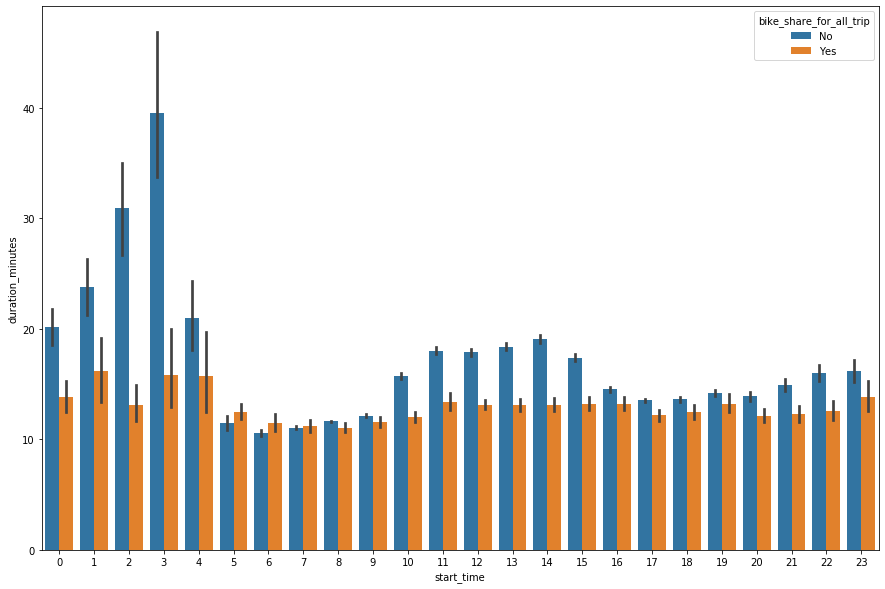

In [55]:
#barplot of the duration and the day hours with bike_share_for_all_trip  as a hue
plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.hour,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.bike_share_for_all_trip,palette=['C0','C1'])

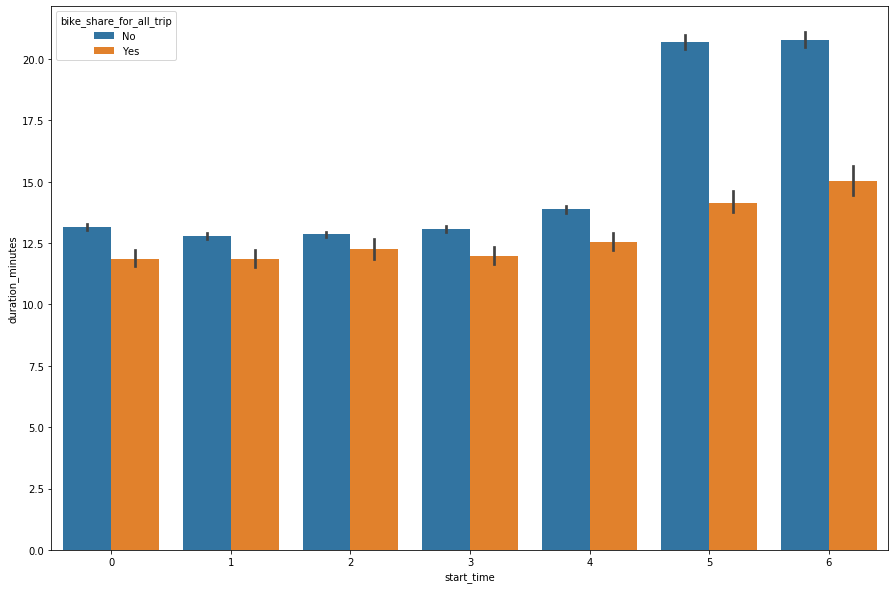

In [56]:
#barplot of the duration and the weekdays with bike_share_for_all_trip  as a hue

plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.dayofweek,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.bike_share_for_all_trip,palette=['C0','C1'])

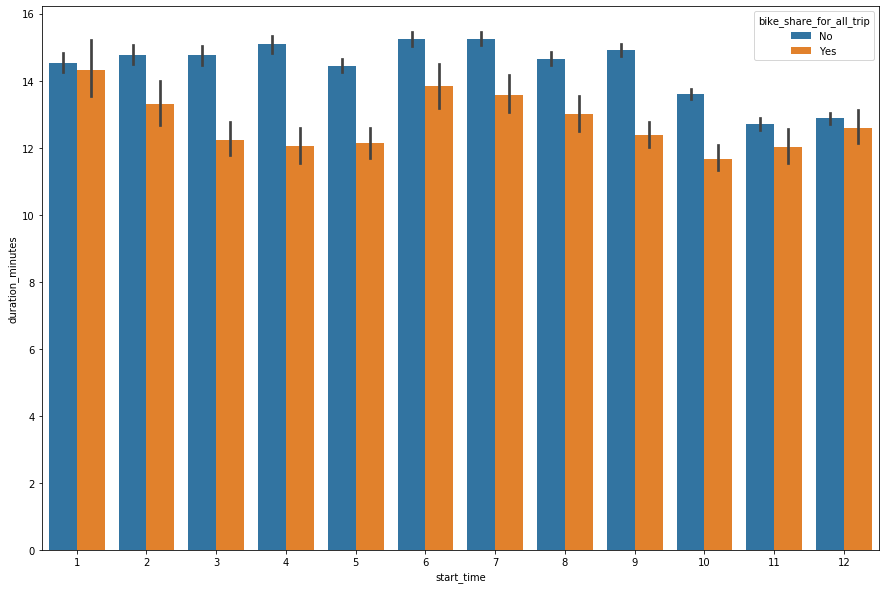

In [57]:
#barplot of the duration and the months with bike_share_for_all_trip  as a hue

plt.figure(figsize=(15,10))
sns.barplot(x=df.start_time.dt.month,y=df.duration_minutes,color=sns.color_palette()[0],hue=df.bike_share_for_all_trip,palette=['C0','C1'])

From the barplots above we can tell that no matter the start time,month or week day of the trip ,trips that are done by members that are enrolled in Bike Share For All program are on average do trips with shorter durations than the ones that are not enrolled.But there's an exception for hourly bases trips that took a place at 5:00,6:00 and 7:00 am where members that are enrolled in the program on average do trips with longer durations than the ones that are not enrolled at these hours.

Now i am going to get line plots of the distance, duration and the user_type.

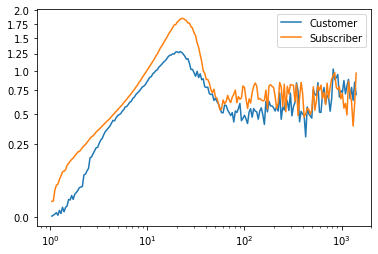

In [58]:
#getting 200 log scaled bins of the duration as minutes when the user type is Customer.

bins_customer = 10**np.linspace(np.log10(df[df.user_type=='Customer'].duration_minutes).min(),
                       np.log10(df[df.user_type=='Customer'].duration_minutes).max(), 200+1)
# getting the centers of the bins.

bin_centers_customer = 0.5*(bins_customer[1:]+ bins_customer[:-1])
#getting the mean of the square root  of the distance for each bin.

data_bins_customer = pd.cut(df[df.user_type=='Customer'].duration_minutes, bins_customer,right=False,include_lowest = True)
means_customer = np.sqrt(df[df.user_type=='Customer'].distance).groupby(data_bins_customer).mean()
#plotting the line of the centers of the bins with the means of the distance when the user type is Customer.

plt.errorbar(x = bin_centers_customer, y = means_customer,label='Customer')
###########################################################################
#getting 200 log scaled bins of the duration as minutes when the user type is Subscriber.

bins_subscriber  = 10**np.linspace( np.log10 ( df[ df.user_type=='Subscriber' ].duration_minutes ).min(),
                       np.log10( df[ df.user_type!='Subscriber' ].duration_minutes ).max(), 200+1)
# getting the centers of the bins.
bin_centers_subscriber = 0.5*(bins_subscriber[1:]+ bins_subscriber[:-1])
#getting the mean of the square root  of the distance for each bin.
data_bins_subscriber = pd.cut(df[df.user_type=='Subscriber'].duration_minutes, bins_subscriber,right=False,include_lowest = True)
means_subscriber = np.sqrt(df[df.user_type=='Subscriber'].distance).groupby(data_bins_subscriber).mean()
#plotting the line of the centers of the bins with the means of the distance when the user type is Customer.
plt.errorbar(x = bin_centers_subscriber, y = means_subscriber,label='Subscriber')

#polishing the plot
plt.legend()
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.yticks(np.sqrt(np.arange(0,2+0.25,0.25)),np.arange(0,2+0.25,0.25))
plt.xscale('log')


The above plot with log scale on the x axis and square root scale on the y axis is a line plot achived by getting the means of the distance over a periods of the duration(bins) then connecting these points to get the line plot for both when the user is a a Subscriber and a Customer . <br>
We can tell from this plot that Customers on average do trips between stations that are in close proximity than the ones that done by  Subscirbers no matter the duration of the trip was.<br>
And we can tell the both curves looks the same like for short durations there's a positive relation between the duration and the distance but after a certain duration falls down and then the curve keeps fluctuating around a certain distance as shown in the plot.

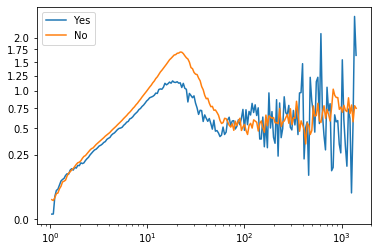

In [59]:

#getting 200 log scaled bins of the duration as minutes when bike_share_for_all_trip equals Yes.
bins_yes = 10**np.linspace(np.log10(df[df.bike_share_for_all_trip=='Yes'].duration_minutes).min(),
                       np.log10(df[df.bike_share_for_all_trip=='Yes'].duration_minutes).max(), 200+1)
# getting the centers of the bins.
bin_centers_yes = 0.5*(bins_yes[1:]+ bins_yes[:-1])
#getting the mean of the square root  of the distance for each bin.
data_bins_yes = pd.cut(df[df.bike_share_for_all_trip=='Yes'].duration_minutes, bins_yes,right=False,include_lowest = True)
means_yes = np.sqrt(df[df.bike_share_for_all_trip=='Yes'].distance).groupby(data_bins_yes).mean()

#plotting the line of the centers of the bins with the means of the distance when bike_share_for_all_trip equals Yes.
plt.errorbar(x = bin_centers_yes, y = means_yes, label='Yes')
################################################################################

#getting 200 log scaled bins of the duration as minutes when bike_share_for_all_trip equals no.

bins_no  = 10**np.linspace( np.log10 ( df[ df.bike_share_for_all_trip=='No' ].duration_minutes ).min(),
                       np.log10( df[ df.bike_share_for_all_trip=='No' ].duration_minutes ).max(), 200+1)
# getting the centers of the bins.
bin_centers_no = 0.5*(bins_no[1:]+ bins_no[:-1])
#getting the mean of the square root  of the distance for each bin.
data_bins_no = pd.cut(df[df.bike_share_for_all_trip=='No'].duration_minutes, bins_no,right=False,include_lowest = True)
means_no = np.sqrt(df[df.bike_share_for_all_trip=='No'].distance).groupby(data_bins_no).mean()

#plotting the line of the centers of the bins with the means of the distance when bike_share_for_all_trip equals Yes.

plt.errorbar(x = bin_centers_no, y = means_no,label='No')

#polishing the plot
plt.legend()
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.yticks(np.sqrt(np.arange(0,2+0.25,0.25)),np.arange(0,2+0.25,0.25))
plt.xscale('log')

This second line plot like the previous one but shows the  relation with bike_share_for_all instade of the user type.


Now i am  going to do some geographical analysis regarding the trips the trips that took a place on January 2018. I chose a one month because the limitaion of my computer to analyse large amount of data.

First by having a new dataframe with trips took a place on January 2018.

In [60]:
df_jan = df[df.start_time.dt.month==1].copy()

Now i am going to plot a figure showing the distribution of the bike stations all around San Francsico.

In [61]:
#checking if there are in san francisco that are used as end stations but not used as start station or the vice-versa.

set(df[df.sf_end].end_station_name)-set(df[df.sf_start].start_station_name)

set()

Because both end_station name and start_station_name have the same unique stations that are located in san francisco , i am going to use start_station_name to get the stations that are located in san francisco.

In [62]:
#getting a  geoseries of the stations names that are located in San Francisco and thier coordinates.
bike_stations=geopandas.GeoSeries(df[df.sf_start].groupby('start_station_name').start_station_coor.unique().explode())

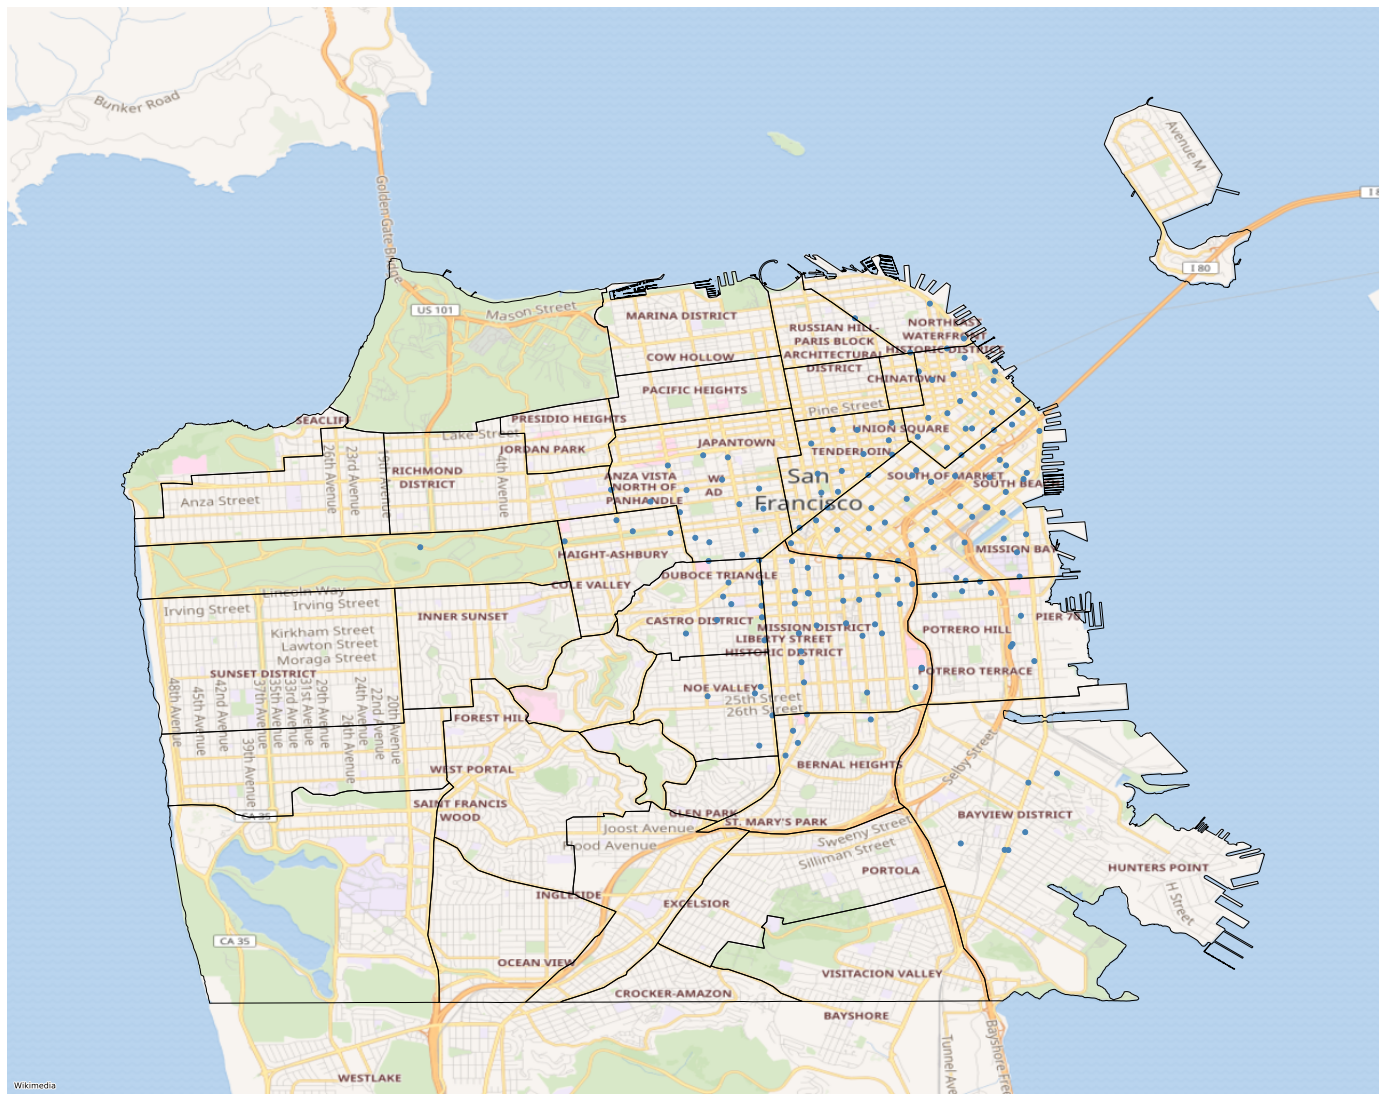

In [63]:
fig,ax=plt.subplots(1,figsize=(25,20))
geoplot.pointplot(bike_stations,ax=ax) # point plot of the stations
geoplot.polyplot(san_francisco,ax=ax,zorder=1) # plot of the neighborhoods boundaries
ctx.add_basemap(ax=ax,crs=san_francisco.crs,url=ctx.providers.Wikimedia); # plot of the of the base map .


From this plot we can see the distribution of the stations on 2018 and we can tell that the north and south western neighborhoods don't have any stations.

Now i am going to plot a plot showing the distribution of the trips count that took a place on San Francisco on January 2018 with respect to the neighborhoods.

In [64]:
start_neighborhood_count_jan = {} # empty dictionary to fill the neighborhoods and the trips count in it .
for neighborhood , geometry in (zip(san_francisco.neighborho,san_francisco.geometry)): # looping over the neighborhoods names and thier boundaries.
    count=df_jan.start_station_coor.apply(lambda x:x.within(geometry)).sum() # apply whithin to get a boolean series of the starting points that are located in the current neighborhood then getting the sum of it to get the number of trips that started in this neighborhood 
    start_neighborhood_count_jan[neighborhood] = count 


I am doing the same above with the end station.

In [65]:
#the same as the cell above but for the end station
end_neighborhood_count_jan = {}
for neighborhood , geometry in (zip(san_francisco.neighborho,san_francisco.geometry)):
    count=df_jan.end_station_coor.apply(lambda x:x.within(geometry)).sum()
    end_neighborhood_count_jan[neighborhood] = count

    


And by having these dictionaries as columns in san_francisco dataframe we are ready to plot our data.

In [66]:
# having the values of start_neighborhood_count_jan and end_neighborhood_count_jan as start_count and end_count columns that are associated with each neighborhood. 
san_francisco['start_count']=start_neighborhood_count_jan.values()
san_francisco['end_count']=end_neighborhood_count_jan.values()

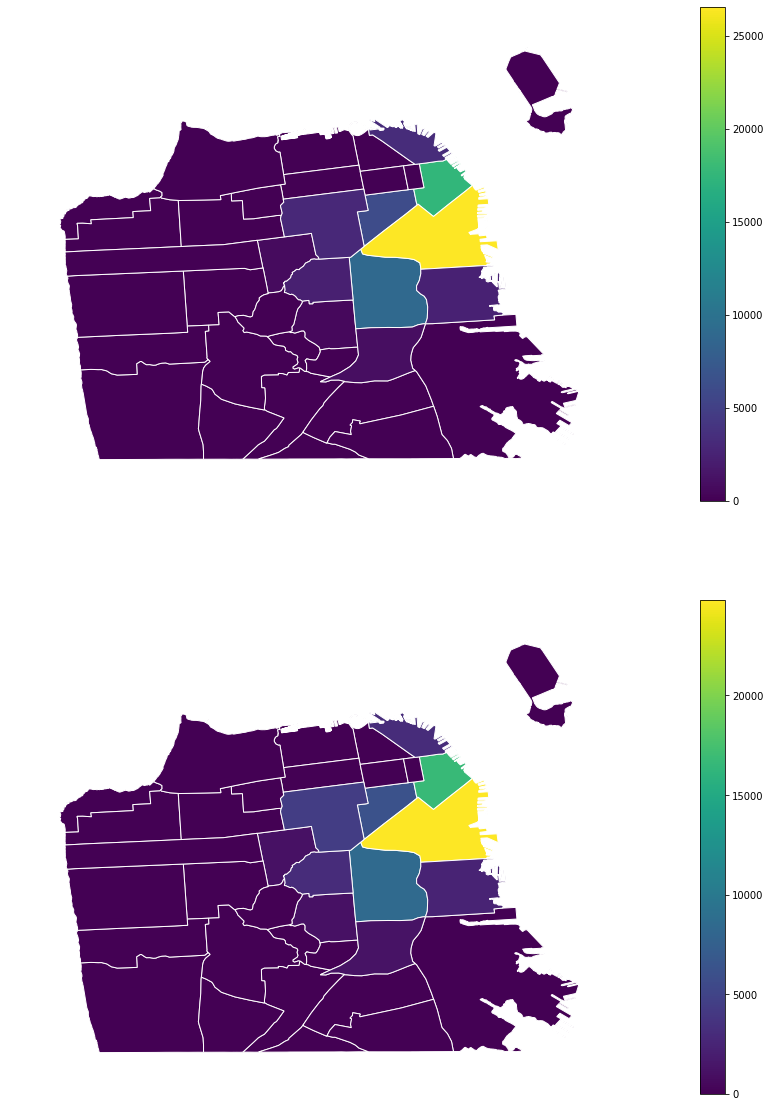

In [67]:
fig,ax=plt.subplots(2,1,figsize=(25,20))
#using choropleth plot a heat map of the count of trips associated to each neighborhood
geoplot.choropleth(
    san_francisco, hue='end_count',
    edgecolor='white', linewidth=1, legend=True,ax=ax[0])
geoplot.choropleth(
    san_francisco, hue='start_count',
    edgecolor='white', linewidth=1, legend=True,ax=ax[1]);



It seems that the trips are not well distributed all around San Francisco neighborhoods. The neighborhoods on the north west of San Franciso are of the higher amount of  trips.

Another approach of doing this is plotting a kde plot shows the distribution of the tips count with a base map showing the neighborhoods. 

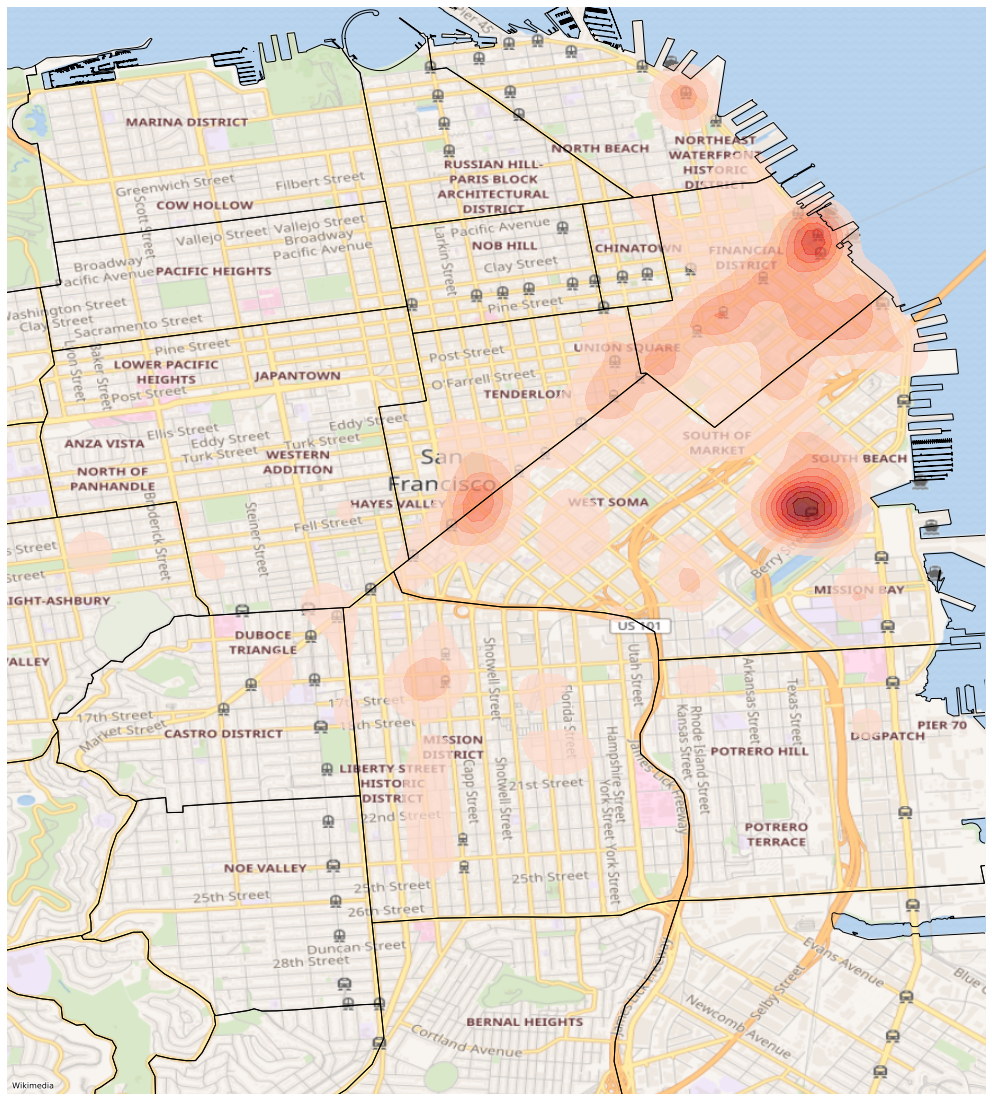

In [68]:
fig,ax=plt.subplots(1,figsize=(25,20))
geoplot.polyplot(san_francisco,ax=ax,zorder=1)#plotting the boundaries of San Francisco neighborhoods

geoplot.kdeplot(geopandas.GeoSeries(df_jan.start_station_coor[df_jan.sf_start==True]),shade=True,cmap='Reds',alpha=0.7,ax=ax)#plotting a kde plot of the trips that started inside San Francisco 
ctx.add_basemap(ax=ax,crs=san_francisco.crs,url=ctx.providers.Wikimedia); #plotting a base map 



Here we see that the South Of Market neighborhood is the one with the hight desnsity of the trips.

Another thing i would like to see is the trips that started inside San Francisco and ended outside the city or the vice-versa .

In [69]:
# getting lines instance and geoseries of these lines that connecting the start and the end stations.
lines_list=[]
for start,end in zip(df.start_station_coor,df.end_station_coor):
    lines_list.append(shapely.geometry.LineString([start,end]))
lines_geoseries=geopandas.GeoSeries(lines_list)

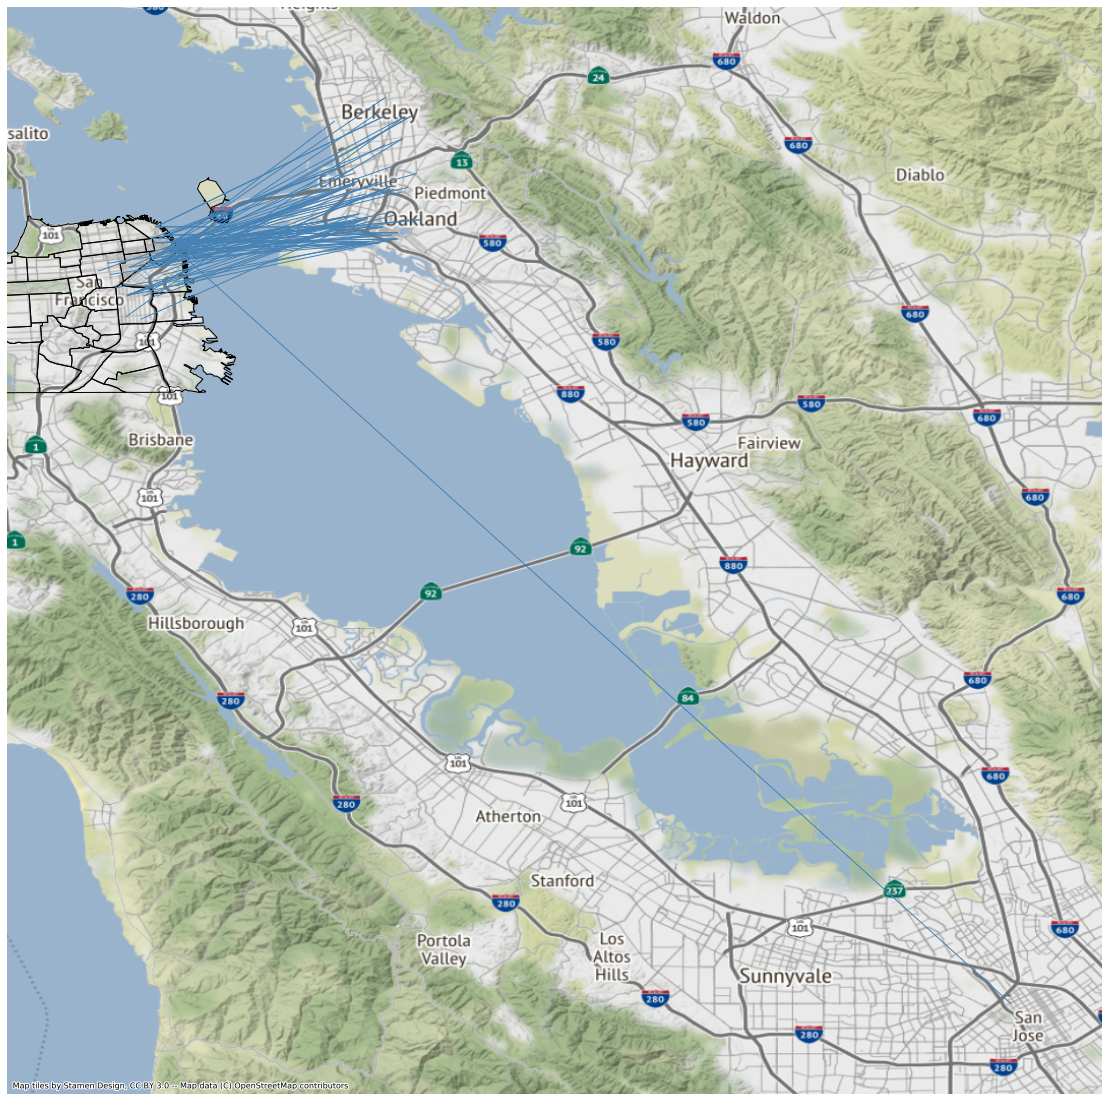

In [70]:
fig,ax=plt.subplots(1,figsize=(25,20))
geoplot.polyplot(san_francisco,ax=ax,zorder=1) # plotting the boundaries of san francisco
geoplot.sankey(lines_geoseries[(df['sf_start']^df['sf_end'])],ax=ax) #plotting the trips that started inside San Francisco and ended outside the city or the vice-versa using xor between sf_start and sf_end.
ctx.add_basemap(ax=ax,crs=san_francisco.crs) # plotting the base map 

So as we see here the over cities trips with respect to San Francisco and we can see the one from San Francisco to San Jose i think it's the outlier trip with a distance of 40.5 miles and its information shown in the cell below.

In [71]:
df.iloc[df.distance.idxmax()]

duration                                 0 days 06:03:56
start_time                    2018-03-29 14:25:47.670000
end_time                      2018-03-29 20:29:44.284000
start_station_id                                      16
start_station_name               Steuart St at Market St
start_station_latitude                           37.7941
start_station_longitude                         -122.394
end_station_id                                       303
end_station_name              San Pedro St at Hedding St
end_station_latitude                             37.3526
end_station_longitude                           -121.906
bike_id                                              319
user_type                                       Customer
bike_share_for_all_trip                               No
start_station_coor           POINT (-122.39443 37.79413)
end_station_coor           POINT (-121.905733 37.352601)
distance                                         40.5806
sf_start                       

References:
- [geoplot documentation](https://residentmario.github.io/geoplot/index.html#)
- [geopandas documentation](https://geopandas.org/)
- [contextily package documentation](https://github.com/darribas/contextily)
- [shapely documentaion](https://shapely.readthedocs.io/en/latest/manual.html)
- [geopy documentation](https://geopy.readthedocs.io/)
- [seaborn documenation](https://seaborn.pydata.org/index.html)
- [matplotlib documentation](https://matplotlib.org/3.1.3/contents.html)